In [ ]:
# import all the classes
from datetime import datetime, date
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tensorflow.compat.v1 as tf

print(tf.__version__)
from time import *
# see readme file to know exact libiaries to install and their functions

2.7.0


# Load data and data preprocessing

In [ ]:
class Processing:
    """ read the data
      and  do some feature engeering
      after define the class, then call each function in the class
      to read the data and do some feature engeering
  """
    def __init__(self, filename):
        self.filename = filename
        if (self.filename[-4:]) == "xlsx":
            self.df = pd.read_excel(self.filename,
                                    parse_dates=["Dates"],
                                    index_col="Dates")
        elif (self.filename[-3:]) == "csv":
            self.df = pd.read_csv(self.filename,
                                  parse_dates=["Dates"],
                                  index_col="Dates")

    # processing the data(Feature engineering)
    def preprocessing(self, lda_list):  #lda is a parameter
        """ do the feature engeering, make features baspread, return and RV
      for each lda values
      Parameters:
            lda_list: list
            Meaning: decaying factors        
      Return:
            No return values"""

        self.df = self.df[[
            'PX_BID', 'PX_ASK', 'PX_LAST', 'PX_OPEN', 'EQY_WEIGHTED_AVG_PX',
            'PX_VOLUME', 'HIST_CALL_IMP_VOL', 'HIST_PUT_IMP_VOL',
            '3MTH_IMPVOL_90.0%MNY_DF', '3MTH_IMPVOL_100.0%MNY_DF',
            '3MTH_IMPVOL_110.0%MNY_DF', '3MO_CALL_IMP_VOL', 'IVOL_MONEYNESS'
        ]]
        self.df['baspread'] = self.df['PX_ASK'] - self.df['PX_BID']
        self.df['Return'] = np.log(self.df['PX_LAST']) - np.log(
            self.df['PX_LAST'].shift())
        for lda in lda_list:  #moving average
            vol = [0]
            ret = self.df['Return'].values
            for i in range(1, len(self.df)):
                vol.append(lda * vol[i - 1] + (1 - lda) * ret[i]**2)
            self.df['RV_%s' % (lda)] = np.sqrt(vol) * 16 * 100
        self.df = self.df.iloc[50:, :]

In [ ]:
data = Processing("GOOGL.csv")

In [ ]:
lda_list = [0.97, 0.94,
            0.87]  # decaying factors used to calculate realized volatility
df = data.preprocessing(lda_list)

In [ ]:
data.df

,PX_BID,PX_ASK,PX_LAST,PX_OPEN,EQY_WEIGHTED_AVG_PX,PX_VOLUME,HIST_CALL_IMP_VOL,HIST_PUT_IMP_VOL,3MTH_IMPVOL_90.0%MNY_DF,3MTH_IMPVOL_100.0%MNY_DF,3MTH_IMPVOL_110.0%MNY_DF,3MO_CALL_IMP_VOL,IVOL_MONEYNESS,baspread,Return,RV_0.97,RV_0.94,RV_0.87
Dates,,,,,,,,,,,,,,,,,,
2014-03-12,603.820,604.246,604.236,598.780,599.7127,1966927,22.952,22.952,25.4448,23.3233,22.6003,23.394,15.3646,0.426,0.006074,16.907505,16.055202,11.630459
2014-03-13,595.107,595.112,595.107,604.561,597.9419,2345640,25.110,25.110,26.2936,24.4009,23.6439,24.479,19.4246,0.005,-0.015224,17.178093,16.670378,13.957512
2014-03-14,586.969,587.029,586.969,591.568,590.2064,2301786,25.341,25.341,26.4527,24.4297,23.7340,24.513,19.8888,0.060,-0.013769,17.343439,17.039620,15.250657
2014-03-17,596.148,596.628,596.628,590.197,595.6752,2166547,24.586,24.586,26.2843,23.9386,22.9913,23.992,18.4585,0.480,0.016322,17.670049,17.715725,17.058871
2014-03-18,606.082,606.353,606.217,597.914,602.9403,1821606,24.401,24.401,26.1100,23.8612,22.9754,23.903,15.9686,0.271,0.015944,17.955156,18.277416,18.378739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-23,2915.870,2916.650,2915.640,2923.060,2910.3419,1361558,23.806,23.806,29.3638,26.6706,25.7892,26.671,23.0475,0.780,-0.003561,22.591813,22.376608,19.466052
2021-11-24,2921.080,2922.810,2922.400,2909.470,2912.9179,902007,24.181,24.181,29.6872,27.0078,26.2199,27.008,23.2699,1.730,0.002316,22.259609,21.713904,18.205810
2021-11-25,2921.080,2922.810,2922.400,2909.470,2912.9179,902007,24.181,24.181,29.6872,27.0078,26.2199,27.008,23.2699,1.730,0.000000,21.923173,21.052411,16.981249


# Plotting RV with different lda

In [ ]:
class plot_RV:
    """ plotting the RV with different decaying factors
      as well as impiled volatility
      after defining the class, call the polt functions
      with lad values list
  """
    def __init__(self, df):
        self.df = df

    def plot(self, lda_list):
        """ 
      plotting the realized and implied volatility
      Parameters:
            lda_list: list
            Meaning: decaying factors        
      Return:
            a plot of 4 cuvres"""
        for lda in lda_list:
            plt.plot(self.df['RV_%s' % (lda)], label='lamda=%s' % (lda))
        plt.plot(self.df['3MO_CALL_IMP_VOL'], label='implied')
        plt.legend(loc='best')
        plt.show()

In [ ]:
plot = plot_RV(data.df)

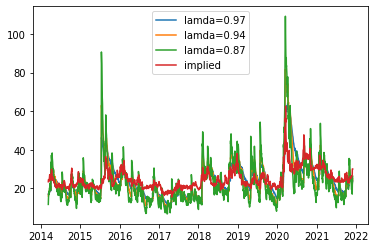

In [ ]:
plot.plot(lda_list)

In [ ]:
def accuracy_trend(x, y, day=1):
    """ 
      trend accuracy, defined by the sign of changes, if predcit the same sign as the changes of implied volatility
      then, it predicts correctly
      Parameters:
            x: numpy.ndarray
            Meaning: the ture values
            y: numpy.ndarray
            Meaning: the predict values  
            day: int
            Meaning: the difference between t and t-day  
      Return:
            type: float
            Meaning: the trend accuracy of the model"""
    return (((pd.Series(x).diff(day) > 0) ==
             (pd.Series(y).diff(day) > 0)).sum() - day) / (len(x) - day)

In [ ]:
#using RV with different lda to predict impolied vol
print(
    accuracy_trend(data.df['3MTH_IMPVOL_100.0%MNY_DF'].values,
                   data.df['RV_0.97'].values))
print(
    accuracy_trend(data.df['3MTH_IMPVOL_100.0%MNY_DF'].values,
                   data.df['RV_0.94'].values))
print(
    accuracy_trend(data.df['3MTH_IMPVOL_100.0%MNY_DF'].values,
                   data.df['RV_0.87'].values))

0.5454545454545454
0.5449577744659712
0.5504222553402881


# Analyzing data and trying to find the best predictors

In [ ]:
class data_analyzing:
    """ analyzing the data, test which feature to include in the model,
      come up with a how we started the process, 
      which features to include, and what parts we should focus on more
      call each function step by step, and see the progress we made to analyze
      the data 
  """
    def __init__(self, df):
        self.df = df
        self.df['dayofweek'] = df.index.dayofweek + 1

    def accuracy_trend(self, x, y, day=1):
        """ 
      trend accuracy, defined by the sign of changes, if predcit the same sign as the changes of implied volatility
      then, it predicts correctly
      Parameters:
            x: numpy.ndarray
            Meaning: the ture values
            y: numpy.ndarray
            Meaning: the predict values  
            day: int
            Meaning: the difference between t and t-day  
      Return:
            type: float
            Meaning: the trend accuracy of the model"""

        return (((pd.Series(x).diff(day) > 0) ==
                 (pd.Series(y).diff(day) > 0)).sum() - day) / (len(x) - day)

    def analyzing_by_days(self):
        """ Sperate the data by days, and for each day calculate the trend accuracy
      Parameters: none
      Return:
            type: float
            Meaning: the trend accuracy of the model"""
        self.dic = {}
        for i in range(1, 6):
            self.dic[str(i)] = self.df[self.df['dayofweek'] == i]
            self.df1 = self.df[self.df['dayofweek'] == i]
            plt.plot(self.df1['RV_0.97'], label='lamda=0.97')
            plt.plot(self.df1['RV_0.94'], label='lamda=0.94')
            plt.plot(self.df1['RV_0.87'], label='lamda=0.87')
            plt.plot(self.df1['3MO_CALL_IMP_VOL'], label='implied')
            plt.legend(loc='best')
            plt.show()
            print('when i = ', i)
            print(
                self.accuracy_trend(
                    self.df1['3MTH_IMPVOL_100.0%MNY_DF'].values,
                    self.df1['RV_0.97'].values))
            print(
                self.accuracy_trend(
                    self.df1['3MTH_IMPVOL_100.0%MNY_DF'].values,
                    self.df1['RV_0.94'].values))
            print(
                self.accuracy_trend(
                    self.df1['3MTH_IMPVOL_100.0%MNY_DF'].values,
                    self.df1['RV_0.87'].values))

    def regiem_change(self):
        """ plot the realized vol and implied vol, find the relationship between each of them,
      to see if there is a good sperator to sperate the data.
      Parameters: none
      Return:
            add regime to the column"""
        # Plot of realzied vols
        plt.plot(self.df['RV_0.97'], label='lamda=0.97')
        plt.plot(self.df['RV_0.94'], label='lamda=0.94')
        plt.plot(self.df['RV_0.87'], label='lamda=0.87')
        plt.plot(self.df['3MO_CALL_IMP_VOL'], label='implied')
        plt.legend(loc='best')
        plt.show()
        plt.figure(figsize=(15, 5))
        # edges = np.arange(0, 10, 10)
        plt.hist(self.df['RV_0.87'], edgecolor='black')
        plt.xlabel('Volume')
        plt.ylabel('frequencies')
        plt.title('Frequencies')
        plt.figure(figsize=(15, 5))
        # edges = np.arange(0, 10, 10)
        plt.hist(self.df['3MO_CALL_IMP_VOL'], edgecolor='black')
        plt.xlabel('Volume')
        plt.ylabel('frequencies')
        plt.title('Frequencies')
        self.df['regiem'] = 0
        self.df.loc[self.df['RV_0.87'] > 30, 'regiem'] = 1
        self.df.loc[self.df['RV_0.87'] > 50, 'regiem'] = 2

    def analyzing_by_regiem(self):
        """ Sperate the data by regimes (based on rv_0.87,0< RV_0.87<30, mark 0
         30<RV_0.87<50, mark 1
         RV_0.87>50, mark 2 
         and for each regime calculate the trend accuracy
      Parameters: none
      Return:
            type: float
            Meaning:the trend accuracy of the model"""
        self.dic = {}
        for i in range(3):
            self.dic[str(i)] = self.df[self.df['regiem'] == i]
            self.df1 = self.df[self.df['regiem'] == i]
            print('when i = ', i)
            print(
                self.accuracy_trend(
                    self.df1['3MTH_IMPVOL_100.0%MNY_DF'].values,
                    self.df1['RV_0.97'].values))
            print(
                self.accuracy_trend(
                    self.df1['3MTH_IMPVOL_100.0%MNY_DF'].values,
                    self.df1['RV_0.94'].values))
            print(
                self.accuracy_trend(
                    self.df1['3MTH_IMPVOL_100.0%MNY_DF'].values,
                    self.df1['RV_0.87'].values))

    def analyzing_by_regiem_days(self):
        """ Sperate the data by regimes and days
         and for each regime and day calculate the trend accuracy
      Parameters: none
      Return:
            type: float
            Meaning: the trend accuracy of the model"""
        self.df1 = self.df[(self.df['regiem'] == 1)
                           & (self.df['dayofweek'] == 1)]
        print("regiem = 1 and dayofweek = 1")
        print(
            self.accuracy_trend(self.df1['3MTH_IMPVOL_100.0%MNY_DF'].values,
                                self.df1['RV_0.97'].values))
        print(
            self.accuracy_trend(self.df1['3MTH_IMPVOL_100.0%MNY_DF'].values,
                                self.df1['RV_0.94'].values))
        print(
            self.accuracy_trend(self.df1['3MTH_IMPVOL_100.0%MNY_DF'].values,
                                self.df1['RV_0.87'].values))

In [ ]:
new_data = data_analyzing(data.df)

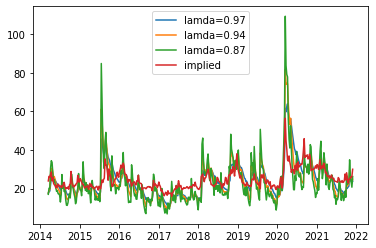

when i =  1
0.554726368159204
0.5746268656716418
0.5796019900497512


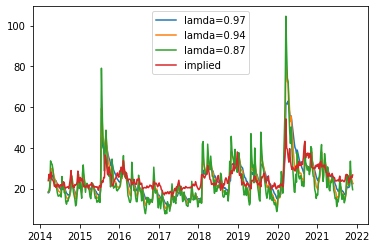

when i =  2
0.5286783042394015
0.5486284289276808
0.5386533665835411


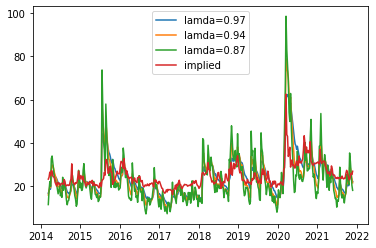

when i =  3
0.5223880597014925
0.5223880597014925
0.5422885572139303


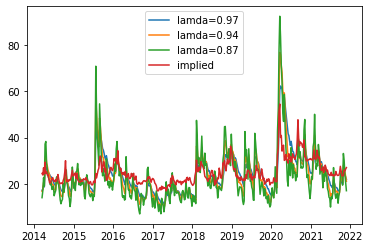

when i =  4
0.5
0.5124378109452736
0.5522388059701493


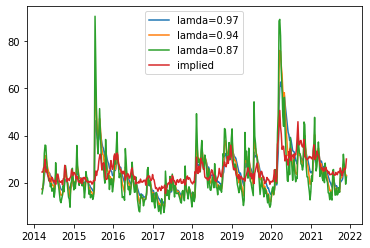

when i =  5
0.5373134328358209
0.5597014925373134
0.5696517412935324


In [ ]:
new_data.analyzing_by_days()

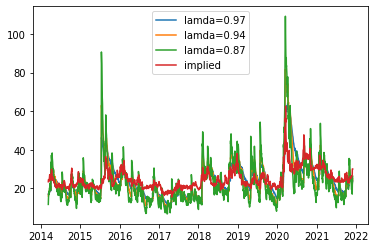

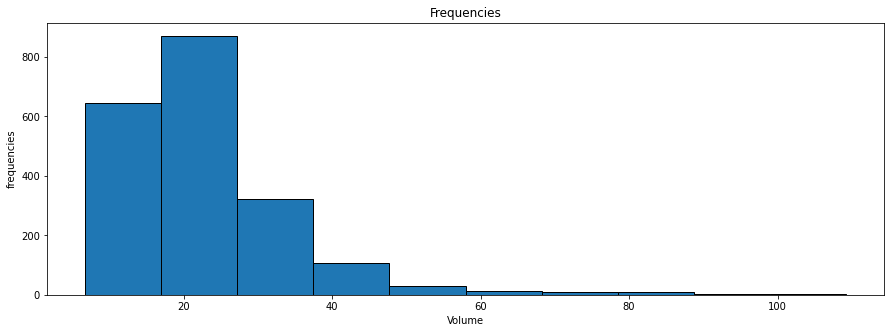

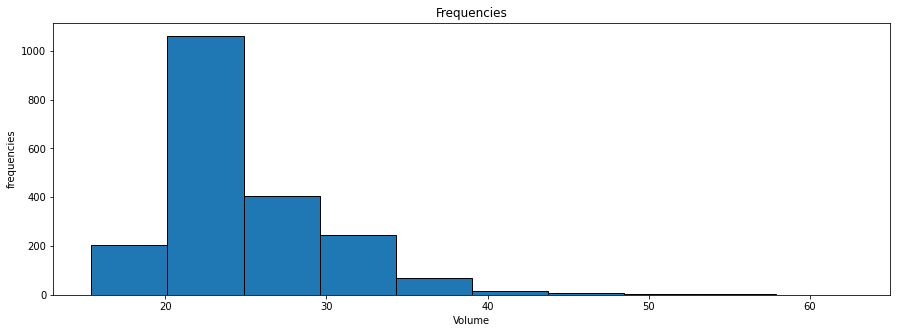

In [ ]:
new_data.regiem_change()

In [ ]:
new_data.analyzing_by_regiem()

when i =  0
0.5336976320582878
0.5349119611414693
0.5415907710989678
when i =  1
0.592948717948718
0.592948717948718
0.5833333333333334
when i =  2
0.5192307692307693
0.4807692307692308
0.5192307692307693


In [ ]:
new_data.analyzing_by_regiem_days()

regiem = 1 and dayofweek = 1
0.582089552238806
0.582089552238806
0.5671641791044776


In [ ]:
# after analyzing the data, we decided to sperate the data into three regiems, according to (0< RV_0.87<30, 30<RV_0.87<50, RV_0.87>50)

# Try different LSTM models to imporve the prediction

In [ ]:
class LSTM_model:
    """ try LSTM model with differnt layers(1,2,3)
      test the model accuracy
      comparsion with the baseline model
      call the functions step by step
  """
    def __init__(self, df):
        df['regiem'] = 0
        df.loc[df['RV_0.87'] > 30, 'regiem'] = 1
        df.loc[df['RV_0.87'] > 50, 'regiem'] = 2
        df1 = df.dropna(how='any')
        dataset = np.array(df1.loc[df['regiem'] == 1, [
            '3MTH_IMPVOL_90.0%MNY_DF', '3MTH_IMPVOL_100.0%MNY_DF',
            '3MTH_IMPVOL_110.0%MNY_DF', 'IVOL_MONEYNESS', 'baspread', 'Return',
            'RV_0.97', 'RV_0.94', 'RV_0.87', 'IVOL_MONEYNESS'
        ]])
        self.dataset = dataset
        self.n_feature = self.dataset.shape[1] - 1
        self.n_time_step = 1

    def split_sequence(self, sequences, n_time_step):
        """ 
      the way of how we constrct data set which suitable for the model
      Parameters:
            sequences: pd.Dataframe
            Meaning: the data set
            n_time_step: int
            Meaning: the way of constructing the data  
      Return:
            type: np.array
            Meaning:the data set we can use as inputs in the LSTM model
      """
        X, y = [], []
        for i in range(len(sequences)):
            end_ix = i + n_time_step

            if end_ix >= len(sequences):
                break
            seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    def split_train_test(self, n_time_step=1, train_rate=0.8):
        """ 
      Sperate the data into training data and test data set
      Parameters:
            train_rate: float
            Meaning: what precentage used as training and test set
            n_time_step: int
            Meaning: the way of constructing the data  
      Return:
            training data set and testing data set
      """
        self.train_sample_num = int(self.dataset.shape[0] *
                                    train_rate)  #shape[0] = number of rows
        #validation_sample_num = self.dataset.shape[0] - train_sample_num
        df_train = self.dataset[:self.train_sample_num, :]
        df_validation = self.dataset[self.train_sample_num:, :]

        self.data_x_train, self.data_y_train = self.split_sequence(
            df_train, n_time_step)
        self.data_x_test, self.data_y_test = self.split_sequence(
            df_validation, n_time_step)

    def fit_model(self, layers):
        """ 
      Fit the LSTM model using differnt layers
      Parameters:
            layers: int
            Meaning: how many layers in the LSTM model 
      Return:
            trained LSTM model
    """
        self.model = Sequential()
        if layers == 1:
            # Train model
            self.model.add(
                LSTM(500,
                     activation='tanh',
                     input_shape=(self.n_time_step, self.n_feature)))
            self.model.add(Dropout(0.3))
            self.model.add(Dense(1, activation='linear'))
            self.model.compile(
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005),
                loss='mse')

        if layers == 2:
            self.model.add(
                LSTM(500,
                     activation='tanh',
                     return_sequences=True,
                     input_shape=(self.n_time_step, self.n_feature)))
            self.model.add(Dropout(0.3))
            self.model.add(LSTM(500, activation='tanh'))
            self.model.add(Dense(1, activation='linear'))
            self.model.compile(
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
                loss='mse')

        if layers == 3:
            # Train model layers = 3
            self.model.add(
                LSTM(500,
                     activation='tanh',
                     return_sequences=True,
                     input_shape=(self.n_time_step, self.n_feature)))
            self.model.add(Dropout(0.3))
            self.model.add(LSTM(500, activation='tanh', return_sequences=True))
            self.model.add(Dropout(0.3))
            self.model.add(LSTM(500, activation='tanh'))
            self.model.add(Dense(1, activation='linear'))
            self.model.compile(
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
                loss='mse')

        # Fit model
        self.model.fit(self.data_x_train,
                       self.data_y_train,
                       batch_size=50,
                       epochs=400)

    def predict_result(self):
        """ 
      Predict the vaule of impolied vol using the model fitted before
      Parameters: none
      Return:
            type:float
            Meaning:the testing MSE of the model
    """
        # Out-of-sample Prediction
        yout = []
        for i in range(len(self.data_x_test)):
            x_input = self.data_x_test[i].reshape(
                (1, self.n_time_step, self.n_feature))
            #print(x_input.shape)
            output = self.model.predict(x_input, verbose=0)
            yout.append(output)
        self.y_pred = np.array(yout)
        self.y_pred = self.y_pred.reshape(-1)
        #print(self.y_pred.shape)
        print('testing MSE: ', mean_squared_error(self.data_y_test,
                                                  self.y_pred))

    def compare_to_baseline(self):
        """ 
      compare the LSTM model with the baseline model
      Parameters: none
      Return:
            type: float and plot
            the testing MSE of the baseline model
            and plot of the curves of two model prediction
    """
        print(
            "MSE of baseline model: ",
            mean_squared_error(self.dataset[self.train_sample_num + 1:, -1],
                               self.dataset[self.train_sample_num:-1, -1]))
        print("Comparison of model prediction and baseline prediction:")
        plt.plot(self.y_pred, label='Model')
        plt.plot(self.data_y_test, label='Baseline')
        plt.legend(loc='best')
        plt.show()

    def accuracy_trend(self, x, y, day=1):
        """ 
      trend accuracy, defined by the sign of changes, if predcit the same sign as the changes of implied volatility
      then, it predicts correctly
      Parameters:
            x: numpy.ndarray
            Meaning: the ture values
            y: numpy.ndarray
            Meaning: the predict values  
            day: int
            Meaning: the difference between t and t-day  
      Return:
            type:float
            Meaning:the trend accuracy of the model
      """
        return (((pd.Series(x).diff(day) > 0) ==
                 (pd.Series(y).diff(day) > 0)).sum() - day) / (len(x) - day)

    def test_accuracy(self):
        """ 
      calculate the trend accuracy of the LSTM model and baseline model by each days
      Parameters: none
      Return:
            type: float
            Meaning: the trend accuracy of each model by differnt days
    """

        print("Day-to-day out-of-sample accuracy: ",
              self.accuracy_trend(self.data_y_test, self.y_pred))
        print("Five-day out-of-sample accuracy: ",
              self.accuracy_trend(self.data_y_test, self.y_pred, 5))
        print(
            "Day-to-day out-of-sample accuracy of baseline: ",
            self.accuracy_trend(self.dataset[self.train_sample_num + 1:, -1],
                                self.dataset[self.train_sample_num:-1, -1]))
        print(
            "Five-day out-of-sample accuracy of baseline: ",
            self.accuracy_trend(self.dataset[self.train_sample_num + 1:, -1],
                                self.dataset[self.train_sample_num:-1, -1], 5))

In [ ]:
class model_plot:
    """ plot the True vs Predict values
      the residual plot
      as well as the trend plot
      after define the class,
      call each function with the LSTM model
      and baseline model, to see the comparsion
      of each model
  """
    def __init__(self, true, pred):
        self.true = true
        self.pred = pred

    def true_pred_plot(self):
        """ 
      the plot of true values vs predict values
      Parameters:
            true: list
            Meaning: the ture values of the model
            predict: list
            Meaning: the predict values of the model
      Return:
            type: plot
            Meaning:the plot of true vs predict values
    """
        plt.scatter(self.pred, self.true)
        plt.plot(self.true, self.true)
        plt.xlabel("predicted value")
        plt.ylabel("true value")
        plt.show()

    def residual_plot(self):
        """ 
      the residual plot (predict values - true values)
      Parameters: none
      Return:
            type: plot
            Meaning:the residual plot
    """
        plt.plot(self.pred - self.true)
        plt.title("Residual plot")
        plt.show()

    def trend_plot(self):
        """ 
      the trend plot (the changes of true values vs the changes of predict values)
      Parameters: none
      Return:
            type:float
            Meaning:the trend plot
    """

        self.true = pd.Series(self.true).diff()
        self.pred = pd.Series(self.pred).diff()
        plt.scatter(self.true, self.pred)
        plt.hlines(0, np.min(self.true), np.max(self.true), color='red')
        plt.vlines(0, np.min(self.pred), np.max(self.pred), color='red')
        plt.xlabel('change of true')
        plt.ylabel('change of pred')
        x = np.linspace(np.floor(np.min(self.true)),
                        np.ceil(np.max(self.true)))
        y = x
        plt.plot(x, y, label='true = pred', color='orange')
        plt.legend()
        plt.show()

# LSTM Model with 1 layer

Epoch 1/400
5/5 [==============================] - 2s 29ms/step - loss: 496.5412
Epoch 2/400
5/5 [==============================] - 0s 29ms/step - loss: 173.0289
Epoch 3/400
5/5 [==============================] - 0s 29ms/step - loss: 144.0431
Epoch 4/400
5/5 [==============================] - 0s 28ms/step - loss: 141.1114
Epoch 5/400
5/5 [==============================] - 0s 28ms/step - loss: 133.0062
Epoch 6/400
5/5 [==============================] - 0s 25ms/step - loss: 130.0450
Epoch 7/400
5/5 [==============================] - 0s 25ms/step - loss: 128.2097
Epoch 8/400
5/5 [==============================] - 0s 23ms/step - loss: 122.5044
Epoch 9/400
5/5 [==============================] - 0s 26ms/step - loss: 121.5371
Epoch 10/400
5/5 [==============================] - 0s 25ms/step - loss: 118.3647
Epoch 11/400
5/5 [==============================] - 0s 25ms/step - loss: 113.7824
Epoch 12/400
5/5 [==============================] - 0s 24ms/step - loss: 122.8767
Epoch 13/400
5/5 [=======

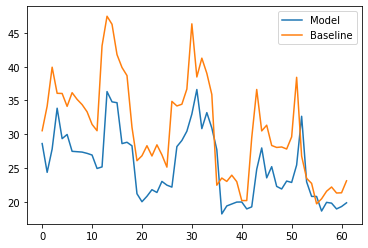

Day-to-day out-of-sample accuracy:  0.5573770491803278
Five-day out-of-sample accuracy:  0.8245614035087719
Day-to-day out-of-sample accuracy of baseline:  0.4918032786885246
Five-day out-of-sample accuracy of baseline:  0.7894736842105263


In [ ]:
LSTM_1 = LSTM_model(data.df)
LSTM_1.split_train_test()
LSTM_1.fit_model(layers=1)
LSTM_1.predict_result()
LSTM_1.compare_to_baseline()
LSTM_1.test_accuracy()

 True VS Pred plot of LSTM Model with 1 layer


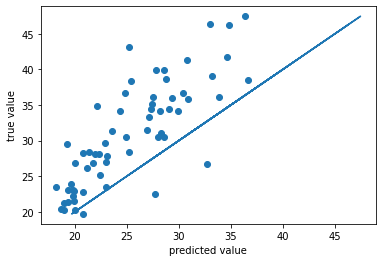

 True VS Pred plot of Baseline Model


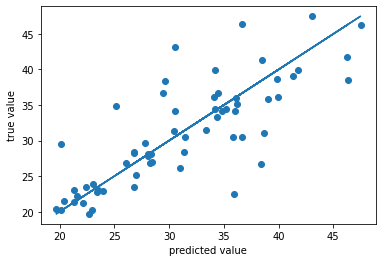

 Residual plot of LSTM Model with 1 layer


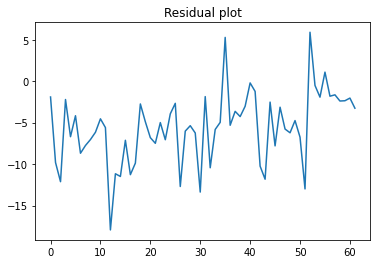

 Residual plot of Baseline Model


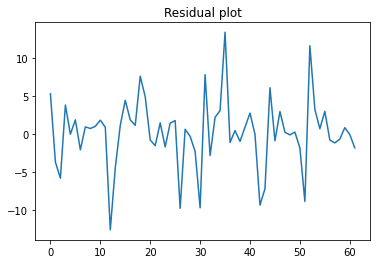

 Trend plot of LSTM Model with 1 layer


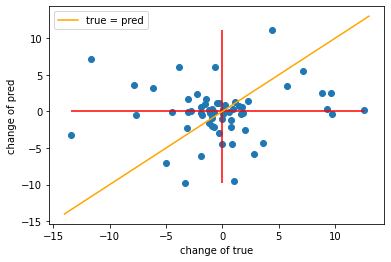

 Trend plot of Baseline Model


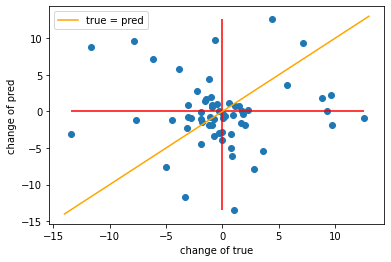

In [ ]:
LSTM_1_plot = model_plot(LSTM_1.data_y_test, LSTM_1.y_pred)
baseline_plot = model_plot(LSTM_1.dataset[LSTM_1.train_sample_num + 1:, -1],
                           LSTM_1.dataset[LSTM_1.train_sample_num:-1, -1])
print(" True VS Pred plot of LSTM Model with 1 layer")
LSTM_1_plot.true_pred_plot()
print(" True VS Pred plot of Baseline Model")
baseline_plot.true_pred_plot()
print(" Residual plot of LSTM Model with 1 layer")
LSTM_1_plot.residual_plot()
print(" Residual plot of Baseline Model")
baseline_plot.residual_plot()
print(" Trend plot of LSTM Model with 1 layer")
LSTM_1_plot.trend_plot()
print(" Trend plot of Baseline Model")
baseline_plot.trend_plot()

# LSTM Model with 2 layers

Epoch 1/400
5/5 [==============================] - 4s 57ms/step - loss: 950.1680
Epoch 2/400
5/5 [==============================] - 0s 58ms/step - loss: 494.9225
Epoch 3/400
5/5 [==============================] - 0s 59ms/step - loss: 276.0236
Epoch 4/400
5/5 [==============================] - 0s 57ms/step - loss: 212.1041
Epoch 5/400
5/5 [==============================] - 0s 61ms/step - loss: 185.7451
Epoch 6/400
5/5 [==============================] - 0s 61ms/step - loss: 170.8381
Epoch 7/400
5/5 [==============================] - 0s 59ms/step - loss: 161.2598
Epoch 8/400
5/5 [==============================] - 0s 56ms/step - loss: 155.0193
Epoch 9/400
5/5 [==============================] - 0s 58ms/step - loss: 150.6508
Epoch 10/400
5/5 [==============================] - 0s 63ms/step - loss: 147.5858
Epoch 11/400
5/5 [==============================] - 0s 57ms/step - loss: 144.7436
Epoch 12/400
5/5 [==============================] - 0s 59ms/step - loss: 140.1644
Epoch 13/400
5/5 [=======

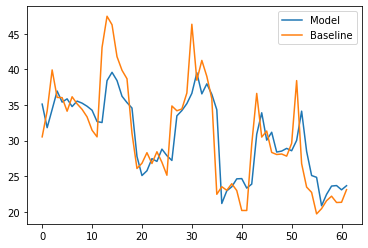

Day-to-day out-of-sample accuracy:  0.5245901639344263
Five-day out-of-sample accuracy:  0.8245614035087719
Day-to-day out-of-sample accuracy of baseline:  0.4918032786885246
Five-day out-of-sample accuracy of baseline:  0.7894736842105263


In [ ]:
LSTM_2 = LSTM_model(data.df)
LSTM_2.split_train_test()
LSTM_2.fit_model(layers=2)
LSTM_2.predict_result()
LSTM_2.compare_to_baseline()
LSTM_2.test_accuracy()

 True VS Pred plot of LSTM Model with 2 layers


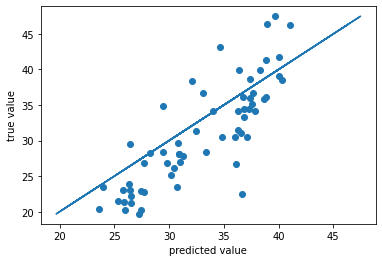

 True VS Pred plot of Baseline Model


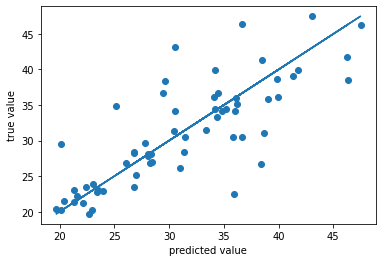

 Residual plot of LSTM Model with 2 layers


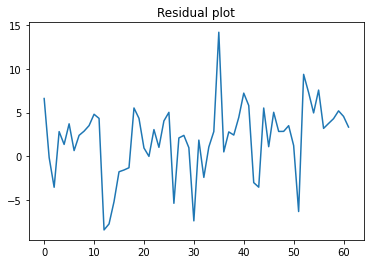

 Residual plot of Baseline Model


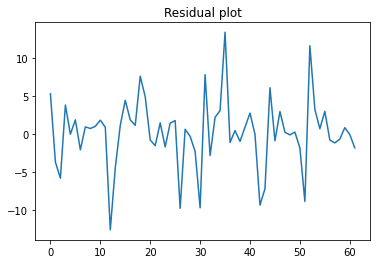

 Trend plot of LSTM Model with 2 layers


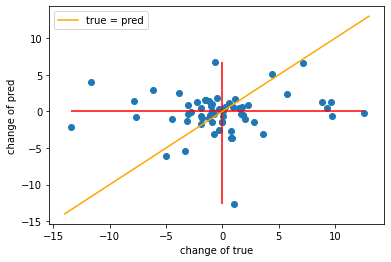

 Trend plot of Baseline Model


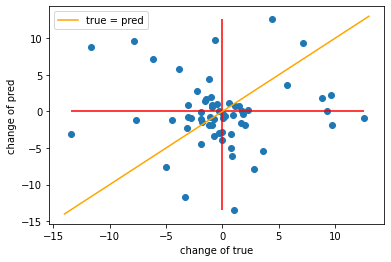

In [ ]:
LSTM_2_plot = model_plot(LSTM_2.data_y_test, LSTM_2.y_pred)
baseline_plot = model_plot(LSTM_2.dataset[LSTM_2.train_sample_num + 1:, -1],
                           LSTM_2.dataset[LSTM_2.train_sample_num:-1, -1])
print(" True VS Pred plot of LSTM Model with 2 layers")
LSTM_2_plot.true_pred_plot()
print(" True VS Pred plot of Baseline Model")
baseline_plot.true_pred_plot()
print(" Residual plot of LSTM Model with 2 layers")
LSTM_2_plot.residual_plot()
print(" Residual plot of Baseline Model")
baseline_plot.residual_plot()
print(" Trend plot of LSTM Model with 2 layers")
LSTM_2_plot.trend_plot()
print(" Trend plot of Baseline Model")
baseline_plot.trend_plot()

# LSTM Model with 3 layers

Epoch 1/400
5/5 [==============================] - 6s 99ms/step - loss: 978.0811
Epoch 2/400
5/5 [==============================] - 0s 89ms/step - loss: 383.1430
Epoch 3/400
5/5 [==============================] - 0s 90ms/step - loss: 219.9250
Epoch 4/400
5/5 [==============================] - 0s 87ms/step - loss: 187.5537
Epoch 5/400
5/5 [==============================] - 0s 88ms/step - loss: 173.1340
Epoch 6/400
5/5 [==============================] - 0s 91ms/step - loss: 163.5319
Epoch 7/400
5/5 [==============================] - 0s 89ms/step - loss: 156.9442
Epoch 8/400
5/5 [==============================] - 0s 93ms/step - loss: 152.5380
Epoch 9/400
5/5 [==============================] - 0s 88ms/step - loss: 149.3941
Epoch 10/400
5/5 [==============================] - 0s 92ms/step - loss: 146.9761
Epoch 11/400
5/5 [==============================] - 0s 86ms/step - loss: 145.6341
Epoch 12/400
5/5 [==============================] - 0s 87ms/step - loss: 144.2821
Epoch 13/400
5/5 [=======

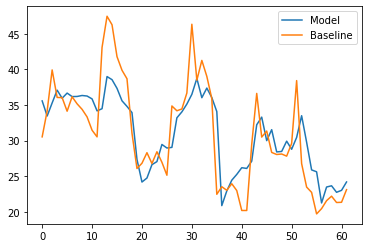

Day-to-day out-of-sample accuracy:  0.6065573770491803
Five-day out-of-sample accuracy:  0.7894736842105263
Day-to-day out-of-sample accuracy of baseline:  0.4918032786885246
Five-day out-of-sample accuracy of baseline:  0.7894736842105263


In [ ]:
LSTM_3 = LSTM_model(data.df)
LSTM_3.split_train_test()
LSTM_3.fit_model(layers=3)
LSTM_3.predict_result()
LSTM_3.compare_to_baseline()
LSTM_3.test_accuracy()

 True VS Pred plot of LSTM Model with 3 layers


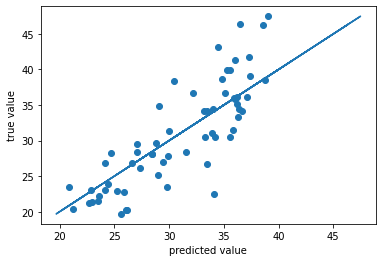

 True VS Pred plot of Baseline Model


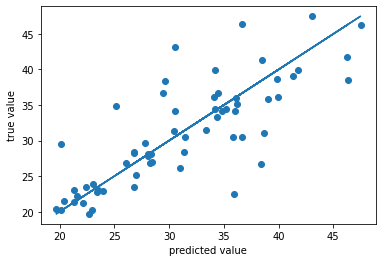

 Residual plot of LSTM Model with 3 layers


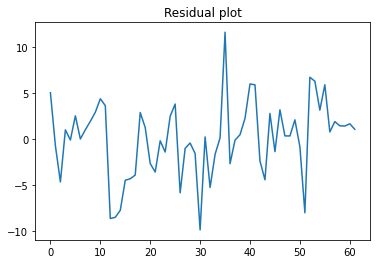

 Residual plot of Baseline Model


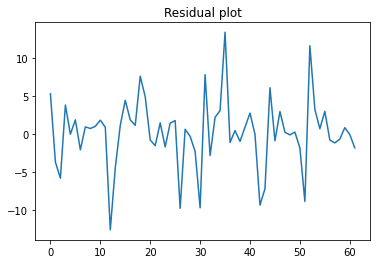

 Trend plot of LSTM Model with 3 layers


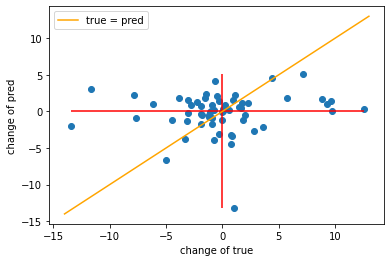

 Trend plot of Baseline Model


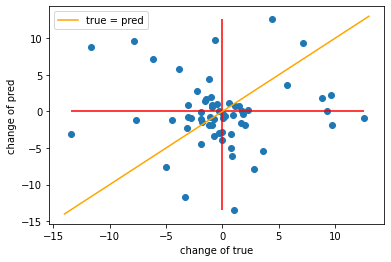

In [ ]:
LSTM_3_plot = model_plot(LSTM_3.data_y_test, LSTM_3.y_pred)
baseline_plot = model_plot(LSTM_3.dataset[LSTM_3.train_sample_num + 1:, -1],
                           LSTM_3.dataset[LSTM_3.train_sample_num:-1, -1])
print(" True VS Pred plot of LSTM Model with 3 layers")
LSTM_3_plot.true_pred_plot()
print(" True VS Pred plot of Baseline Model")
baseline_plot.true_pred_plot()
print(" Residual plot of LSTM Model with 3 layers")
LSTM_3_plot.residual_plot()
print(" Residual plot of Baseline Model")
baseline_plot.residual_plot()
print(" Trend plot of LSTM Model with 3 layers")
LSTM_3_plot.trend_plot()
print(" Trend plot of Baseline Model")
baseline_plot.trend_plot()